In [1]:
#!/usr/bin/env python
# coding: utf-8

import os

IMG_PATH = "_img"
CACHE_PATH = "../analysis/_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.io import load_libraries
from MaStarChecks.plotting.styles import *


PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.1")

LABELS = ("MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

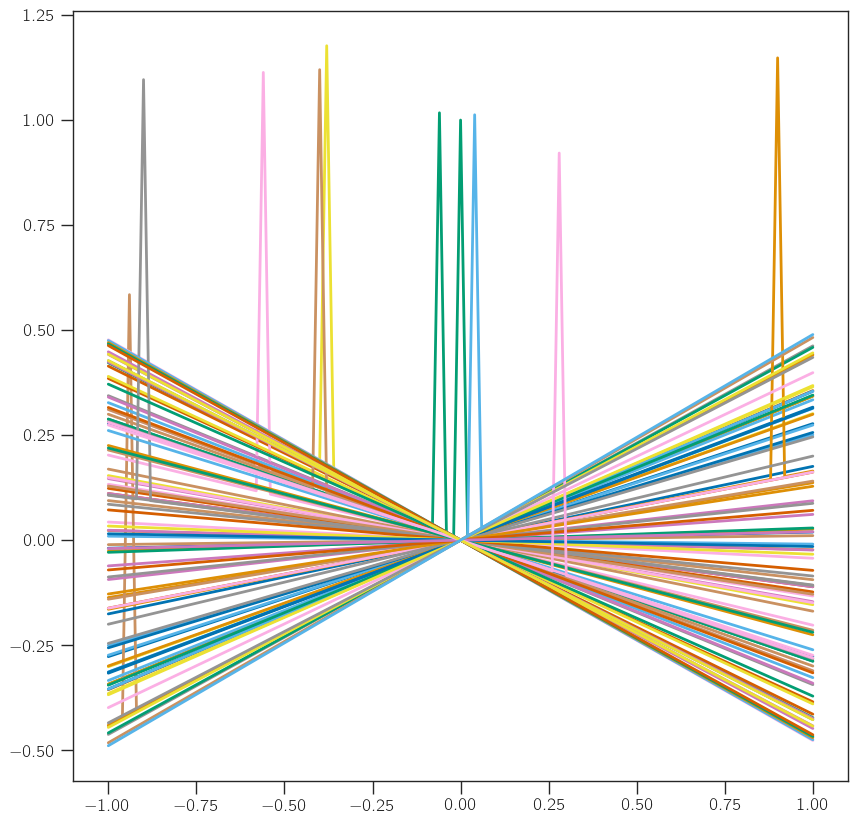

In [2]:
Nf, Ns = 101, 100
olf = 0.1
ola = 1

x = np.linspace(-1, 1, Nf)
slopes = (0.5 + 0.5) * np.random.random_sample(Ns) + -0.5

X = np.repeat([x], Ns, axis=0) * slopes[:,None]

idx_ol = np.random.choice(np.arange(Ns), size=int(np.floor(100*olf)), replace=False)
for i in idx_ol:
    j = np.random.choice(np.arange(Nf))
    X[i, j] += ola

for y in X:
    plt.plot(x, y)

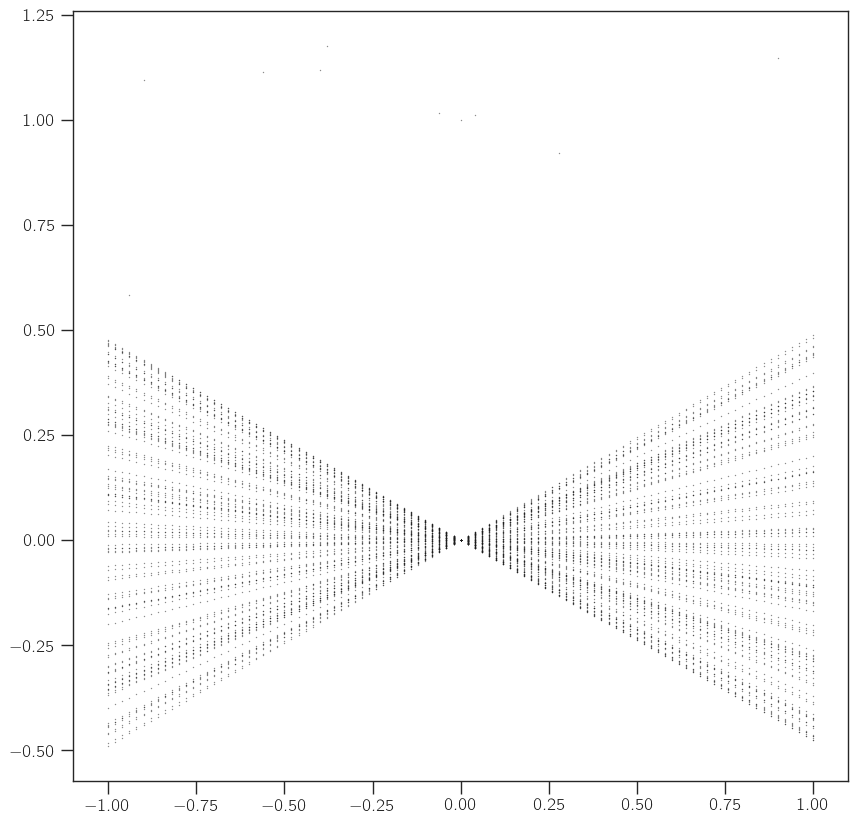

In [3]:
from sklearn.neighbors import LocalOutlierFactor


clf = LocalOutlierFactor()
y_pred = clf.fit_predict(X.T)
X_scores = clf.negative_outlier_factor_
radius = 1000 * (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

for i, y in enumerate(X):
    plt.scatter(x, y, lw=0, s=1, c="k", alpha=0.5)

In [4]:
spectra, catalogue = load_libraries(
    labels=LABELS,
    libraries_path=PROCESSED_PATH,
    use_cache=True, cache_path=CACHE_PATH,
    cache_label="M20-cleaned-v2"
)
spectra = spectra["MaStar"]["FLUX"]
catalogue = catalogue["MaStar"]

In [6]:
# plt.hist(lof.negative_outlier_factor_, 100);

Text(0, 0.5, '$F_\\lambda/F_{5500}$')

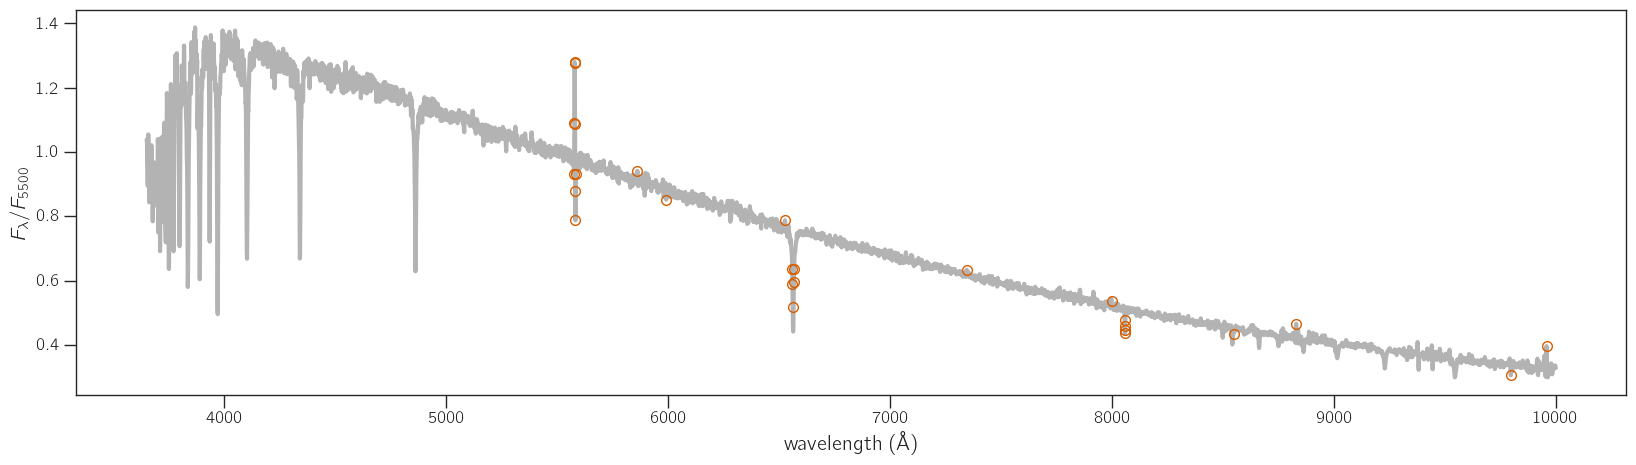

In [27]:
from scipy.spatial.distance import pdist, squareform, euclidean
from sklearn.neighbors import LocalOutlierFactor


metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2',
      'manhattan'] + ['braycurtis', 'canberra', 'chebyshev',
      'correlation', 'dice', 'hamming', 'jaccard', 'kulsinski',
      'mahalanobis', 'minkowski', 'rogerstanimoto', 'russellrao',
      'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean',
      'yule']

lof = LocalOutlierFactor(5, metric="precomputed", contamination=0.004)

spec = 8

spectrum = spectra.loc[spec].reset_index().values
spectrum[:, 0] = np.log10(spectrum[:, 0])
distance_vector = pdist(spectrum, metric="euclidean")
lof.fit(squareform(distance_vector))
outliers = lof.fit_predict(squareform(distance_vector)) == -1

plt.figure(figsize=(20,5))
spectra.loc[spec].plot(color="0.7", lw=3)
# spectra.loc[spec].loc[~outliers].plot(lw=0.5)
plt.plot(spectra.loc[spec].index[outliers], spectra.loc[spec].values[outliers], "or", ms=7, mfc="none", mec="r", mew=1)
plt.xlabel("wavelength (\AA)")
plt.ylabel("$F_\lambda/F_{5500}$")

In [8]:
from astropy.modeling.models import Polynomial1D

from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import find_lines_threshold, find_lines_derivative, fit_continuum
from specutils.manipulation import noise_region_uncertainty
from astropy import units as u


spectrum = Spectrum1D(flux=spectra.loc[spec].values*u.erg/u.cm**2/u.s/u.AA, spectral_axis=spectra.columns.values*u.AA)

region = SpectralRegion(5450*u.AA, 5550*u.AA)
spectrum = noise_region_uncertainty(spectrum, region)

g1_fit = fit_continuum(spectrum, model=Polynomial1D(degree=7))
continuum_fitted = g1_fit(spectra.columns.values*u.AA)

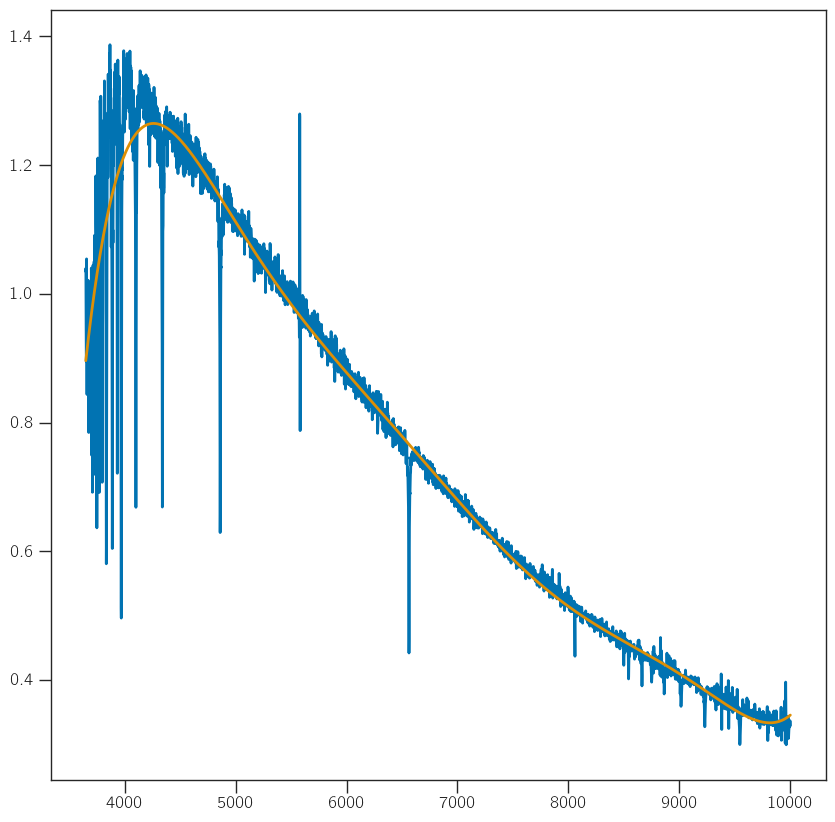

In [9]:
spectra.loc[spec].plot()
plt.plot(spectra.columns, continuum_fitted)


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


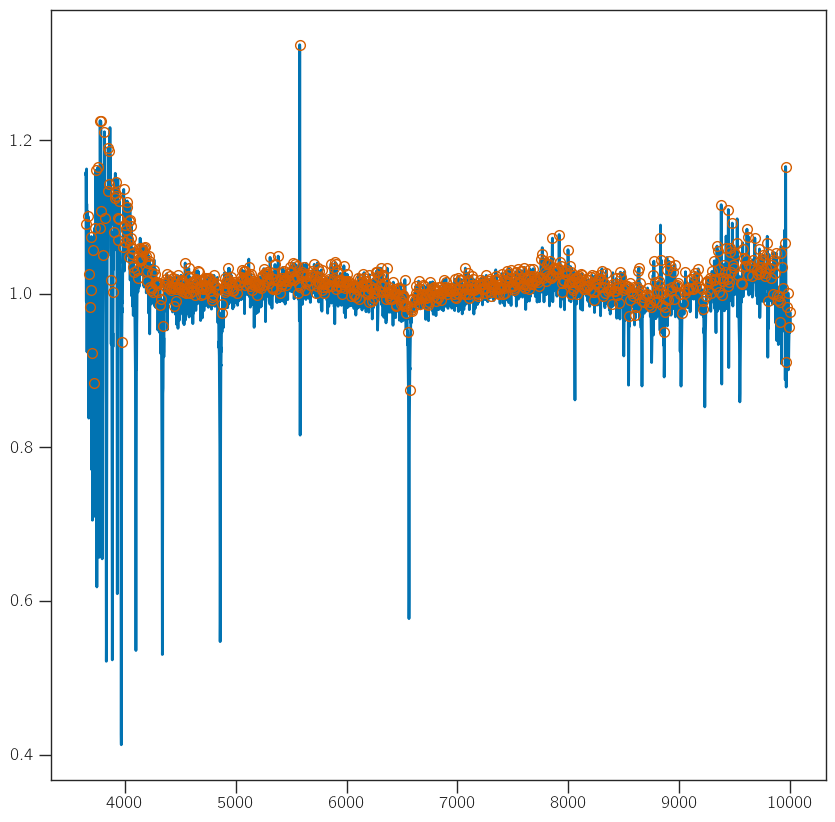

In [10]:
normalized_spectrum = spectrum/continuum_fitted

peak_detection = find_lines_derivative(spectrum)
outliers = peak_detection["line_center_index"][peak_detection["line_type"]=="emission"]

plt.plot(normalized_spectrum.spectral_axis, normalized_spectrum.flux)
plt.plot(normalized_spectrum.spectral_axis[outliers], normalized_spectrum.flux[outliers], "or", ms=7, mfc="none", mec="r", mew=1)

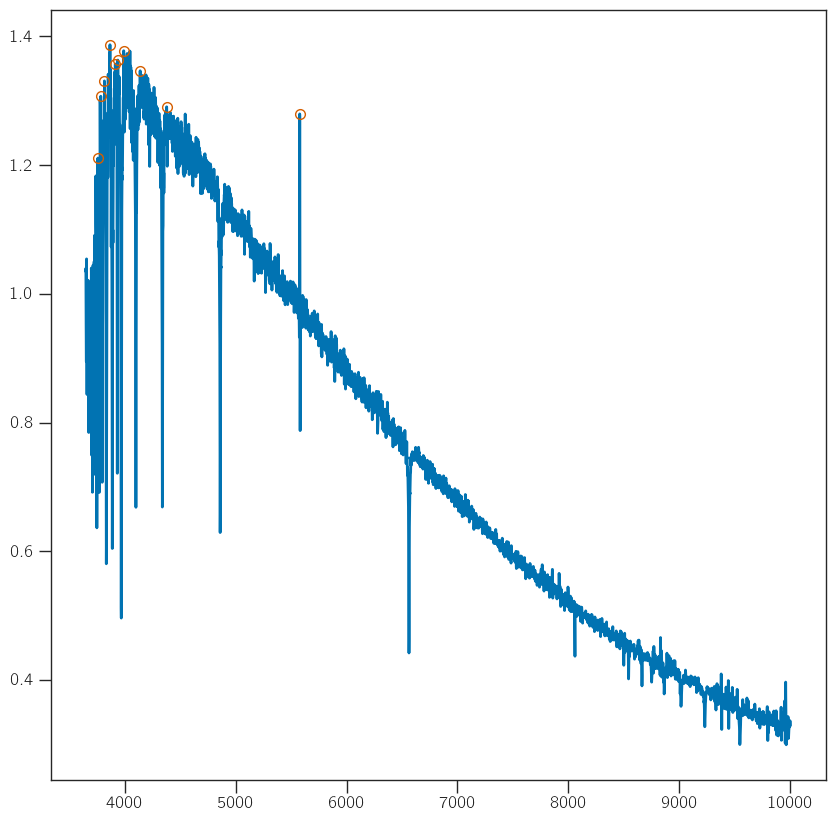

In [11]:
from scipy.signal import find_peaks


outliers = find_peaks(spectra.loc[spec].values, prominence=0.5)[0]

spectra.loc[spec].plot()
plt.plot(spectra.loc[spec].index[outliers], spectra.loc[spec].values[outliers], "or", ms=7, mfc="none", mec="r", mew=1)

In [14]:
# dist, idx = lof.kneighbors(spectra.loc[spec].values[:,None])